# Workflow for Generating `.toml` Files 

The simplest way to generate a toml file for a pyRISM calculation is by using the acpype server, or the CLI tool, to rapidly patametrise molecules and the parmed and toml libraries to generate a `.toml` file. This process can be automated to batch create `.toml` files for large datasets.

The acpype CLI tool can be installed via conda using `conda install -c conda-forge acpype`. 

I would recommend creating a new environment first before doing this e.g. `conda create -n acpype_env`.

Once installed, we can then parametrise files using the command `acpype -i <input_file>`.

Take for example the included `002dime_5_CM5.mol2` file&mdash;which we will be using as a solute:
```
acpype -i 002dime_5_CM5.mol2
```

This generates a folder named `002dime_5_CM5.acpype` that contains the parameters we want in various different formats. We will use the parmed library to parse the parameters and the toml library to generate a toml file.

You can technically pick any format you want (CHARMM, GROMACS, CNS or Amber)...

In [1]:
import parmed as pmd
import toml
import os
from tabulate import tabulate # for pretty and readable printing of data we're working with
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We're interested in extracting the charges, non-bonding parameters (Lennard-Jones $\epsilon$ and $\sigma$) and coordinates. Before we do any extracting, let's just check that we get the values we expect and what their units are.

In [2]:
parm_mol = pmd.load_file('002dime_5_CM5.acpype/002dime_5_CM5_AC.prmtop', xyz='002dime_5_CM5.acpype/002dime_5_CM5_AC.inpcrd')
atom_table = []
for (atom, coord) in zip(parm_mol.atoms, parm_mol.coordinates):
    atom_table.append([atom.name, atom.type, atom.urmin, atom.usigma, atom.uepsilon, atom.ucharge, coord])

print(tabulate(atom_table, headers=["Atom name",
    "Atom type",
    "Rmin",
    "Sigma",
    "Epsilon",
    "Charge",
    "Coordinates"],
    tablefmt="github"))

| Atom name   | Atom type   | Rmin                 | Sigma                | Epsilon                       | Charge                  | Coordinates            |
|-------------|-------------|----------------------|----------------------|-------------------------------|-------------------------|------------------------|
| C           | c3          | 1.9069000000076504 A | 3.397709531257257 A  | 0.1078000000751509 kcal/mol   | -0.09485000027438907 e  | [-1.534  0.593  0.096] |
| C1          | c3          | 1.9069000000076504 A | 3.397709531257257 A  | 0.1078000000751509 kcal/mol   | -0.058699999999999995 e | [-0.31   1.509 -0.089] |
| C2          | c3          | 1.9069000000076504 A | 3.397709531257257 A  | 0.1078000000751509 kcal/mol   | -0.09485000027438907 e  | [ 0.322  1.31  -1.48 ] |
| C3          | c3          | 1.9069000000076504 A | 3.397709531257257 A  | 0.1078000000751509 kcal/mol   | -0.1804 e               | [0.715 1.394 1.072]    |
| C4          | c           | 1.86060000004729

As we can see in the table, the units for $\sigma$ is Angstroms which is what we want.
In the case of $\epsilon$ however, we want to cast it into the form $\frac{\epsilon}{k_B}$ to make things easier for ourselves later down the line.

We want to generate the `[solute]` section of our `.toml` file (we will come back to `[solvent]` later). The TOML library represents the structure of a file as a `dict` in Python. To get an idea of the structure, please look at the [wiki](https://github.com/2AUK/pyRISM/wiki#structure-of-an-input-file).

In order to generate this `dict`, we will need to construct sub-`dicts` and then bring them altogether.
Firstly we should define the density and the number of sites for the species we're looking at in a `dict` named `species_info`:

In [3]:
species_info = {}
species_info['dens'] = 0.0 # infinite dilution
species_info['ns'] = len(parm_mol.atoms)

Next we populate the force field parameters, charges and coordinates for each site. 
The name of the atom will act as the key for the `dict`.
We want to make sure that each site is uniquely named in the `dict` - two atoms named the same in the `.prmtop` will overwrite each other in the `dict`. In order to do that, we can add a number to the key.
Then we can generate the entries as such (remembering to convert $\epsilon$ to $\frac{\epsilon}{k_B}$):

In [4]:
for i, (atom, coord) in enumerate(zip(parm_mol.atoms, parm_mol.coordinates)):
    species_info[atom.name + '-' + str(i)] = [[atom.epsilon / 1.987204259E-3, atom.sigma, atom.charge], coord]

Next we place the `species_info` into a sub-heading under the `[solute]` header, named `[solute.002dime_5_CM5_AC]` (the name of our input file) as well as information on the number of species and the total number of sites across all species. This is as simple as placing `species_info` in another dict:

In [5]:
species = {}
species['nspu'] = 1 # only looking at one solute species at the moment
species['nsu'] = species_info['ns'] # since we're only looking at one solute, the total number of sites is the same as the number of sites of our single solute

# Add the species as a subheader
name = os.path.basename(parm_mol.name).split('.')[0] # extracting the name of the file from the path given to Parmed earlier
species[name] = species_info
print(species)

{'nspu': 1, 'nsu': 28, '002dime_5_CM5_AC': {'dens': 0.0, 'ns': 28, 'C-0': [[54.24706573917971, 3.397709531257257, -0.09485000027438907], array([-1.534,  0.593,  0.096])], 'C1-1': [[54.24706573917971, 3.397709531257257, -0.058699999999999995], array([-0.31 ,  1.509, -0.089])], 'C2-2': [[54.24706573917971, 3.397709531257257, -0.09485000027438907], array([ 0.322,  1.31 , -1.48 ])], 'C3-3': [[54.24706573917971, 3.397709531257257, -0.1804], array([0.715, 1.394, 1.072])], 'C4-4': [[49.71808990041869, 3.3152123100281, 0.5710999983536655], array([1.39 , 0.03 , 1.244])], 'O-5': [[73.62101783947054, 3.048120873800651, -0.5341], array([ 0.861, -0.853,  1.922])], 'C5-6': [[54.24706573917971, 3.397709531257257, -0.1804], array([ 2.744, -0.175,  0.551])], 'C6-7': [[54.24706573917971, 3.397709531257257, -0.058699999999999995], array([ 3.17 , -1.643,  0.296])], 'C7-8': [[54.24706573917971, 3.397709531257257, -0.09485000027438907], array([ 4.638, -1.7  , -0.157])], 'C8-9': [[54.24706573917971, 3.397709

We have the solute information now stored in `species`.
We still need to add the three other sections, `[system]`, `[params]` and `[solvent]`. Fortunately, the former two are quite small so we can actually just hand-write them in the correct TOML format and parse them into `dicts` directly using the toml library.

In [6]:
system = """[system]
temp = 298.15
kT = 1.0 
kU = 0.00198720414667 
charge_coeff = 167101.0
npts = 1024
radius = 10.24
lam = 1
"""
params="""[params]
potential = "LJ"
closure = "KH"
IE = "DRISM"
solver = "MDIIS"
picard_damping = 0.1
mdiis_damping = 0.7
depth = 12
itermax = 10000
tol = 1e-7
diel = 78.4
adbcor = 1.0
"""

Note: at this point we set `kT` to 1 because we have already scaled our values for $\epsilon$ by $k_B = 1.987204259\times10^{-3}$. If we kept the values in units kcal/mol then we would need to set `kT = 1.987204259E-3` here.

We can parse these now using the toml library:

In [7]:
system = toml.loads(system)
params = toml.loads(params)

print(system)
print(params)

{'system': {'temp': 298.15, 'kT': 1.0, 'kU': 0.00198720414667, 'charge_coeff': 167101.0, 'npts': 1024, 'radius': 10.24, 'lam': 1}}
{'params': {'potential': 'LJ', 'closure': 'KH', 'IE': 'DRISM', 'solver': 'MDIIS', 'picard_damping': 0.1, 'mdiis_damping': 0.7, 'depth': 12, 'itermax': 10000, 'tol': 1e-07, 'diel': 78.4, 'adbcor': 1.0}}


The final section we need is `[solvent]`. We can hard-code this just like the system and params sections above.

We can also read in `.mdl` file from AmberTools (used to define the solvent parameters for 3D-RISM calculations).
Say we want to add the cSPC/E water model and Deng's NaCl parameters, we can use parmed to read those files too.

Parmed reads a `.mdl` file is slightly different to reading a `.prmtop` file and as a result we have to approach this differently.
We are exposed to the raw format of the `.mdl` file instead. We also need to account for the multiplicity defined by Amber `.mdl` files as well as the units.

Amber `.mdl` files use Rmin/2 rather than $\sigma$, but still in Angstroms. The converersion from Rmin to $\sigma$ is given as: 
$$\frac{R_\text{min}}{2} = \frac{2^{\frac{1}{6}}\sigma}{2}$$

The easiest is to define a constant to multiply by `RMIN2_TO_SIGMA = 2 * 2 ** (-1.0 / 6.0)`.

$\epsilon$ is simply given in kcal/mol, so we can divide by $k_B = 1.987204259\times10^{-3}$ again here.

Finally, Amber defines the charge as $18.223e$. We simply need to divide by $18.223$.

In [8]:
solv_dat = pmd.load_file('cSPCE.mdl')
na_dat = pmd.load_file('deng_95/Na+.mdl')
cl_dat = pmd.load_file('deng_95/Cl-.mdl')

solvent_table = []

RMIN2_TO_SIGMA = 2 * 2 ** (-1.0 / 6.0)
CHARGE_CONVERSION = 18.2223

# Let's visualise the data
for i in range(len(solv_dat.parm_data['ATMNAME'])):
    for j in range(solv_dat.parm_data['MULTI'][i]):
        row_dat = [solv_dat.parm_data['ATMNAME'][i] + str(i+j), solv_dat.parm_data['LJSIGMA'][i] * RMIN2_TO_SIGMA, solv_dat.parm_data['LJEPSILON'][i] / 1.987204259E-3, solv_dat.parm_data['CHG'][i] / CHARGE_CONVERSION]
        x = solv_dat.parm_data['COORD'][(i+j) * 3]
        y = solv_dat.parm_data['COORD'][((i+j) * 3) + 1]
        z = solv_dat.parm_data['COORD'][((i+j) * 3) + 2]
        row_dat.append([x, y, z])
        solvent_table.append(row_dat)
print(tabulate(solvent_table, headers=["Atom name",
    "Sigma",
    "Epsilon",
    "Charge",
    "Coordinates"],
    tablefmt="github"))

| Atom name   |   Sigma |   Epsilon |   Charge | Coordinates                |
|-------------|---------|-----------|----------|----------------------------|
| O0          | 3.16572 |    78.15  |  -0.8476 | [0.0, 0.0, 0.0]            |
| H11         | 1.16572 |     7.815 |   0.4238 | [1.0, 0.0, 0.0]            |
| H12         | 1.16572 |     7.815 |   0.4238 | [-0.333314, 0.942816, 0.0] |


We can approach the Na+ and Cl- files in a similar manner (ideally you'd put all this functionality into one function you call multiple times):

In [9]:
for i in range(len(na_dat.parm_data['ATMNAME'])):
    for j in range(na_dat.parm_data['MULTI'][i]):
        row_dat = [na_dat.parm_data['ATMNAME'][i] + str(i+j), na_dat.parm_data['LJSIGMA'][i] * RMIN2_TO_SIGMA, na_dat.parm_data['LJEPSILON'][i] / 1.987204259E-3, na_dat.parm_data['CHG'][i] / CHARGE_CONVERSION]
        x = na_dat.parm_data['COORD'][(i+j) * 3]
        y = na_dat.parm_data['COORD'][((i+j) * 3) + 1]
        z = na_dat.parm_data['COORD'][((i+j) * 3) + 2]
        row_dat.append([x, y, z])
        solvent_table.append(row_dat)

for i in range(len(cl_dat.parm_data['ATMNAME'])):
    for j in range(cl_dat.parm_data['MULTI'][i]):
        row_dat = [cl_dat.parm_data['ATMNAME'][i] + str(i+j), cl_dat.parm_data['LJSIGMA'][i] * RMIN2_TO_SIGMA, cl_dat.parm_data['LJEPSILON'][i] / 1.987204259E-3, cl_dat.parm_data['CHG'][i] / CHARGE_CONVERSION]
        x = cl_dat.parm_data['COORD'][(i+j) * 3]
        y = cl_dat.parm_data['COORD'][((i+j) * 3) + 1]
        z = cl_dat.parm_data['COORD'][((i+j) * 3) + 2]
        row_dat.append(np.asarray([x, y, z]))
        solvent_table.append(row_dat)

print(tabulate(solvent_table, headers=["Atom name",
    "Sigma",
    "Epsilon",
    "Charge",
    "Coordinates"],
    tablefmt="github"))

| Atom name   |   Sigma |   Epsilon |   Charge | Coordinates                |
|-------------|---------|-----------|----------|----------------------------|
| O0          | 3.16572 |    78.15  |  -0.8476 | [0.0, 0.0, 0.0]            |
| H11         | 1.16572 |     7.815 |   0.4238 | [1.0, 0.0, 0.0]            |
| H12         | 1.16572 |     7.815 |   0.4238 | [-0.333314, 0.942816, 0.0] |
| Na+0        | 2.30208 |    50.322 |   1      | [0.0, 0.0, 0.0]            |
| Cl-0        | 3.92085 |    50.322 |  -1      | [0. 0. 0.]                 |


We have three sets of parameter data that we need to construct `dicts` for, and then populate the `[solvent]` header with those dicts.
We can set up the overaching `dict` that contains all the solvent species information and populate that `dict`.

We also need to supply density information, which we do in a separate list that we loop over.

In [10]:
solv_species = {}
pmd_dat = [solv_dat, na_dat, cl_dat]
pmd_dens = [3.3272748E-2, 0.06022E-3, 0.06022E-3]
total = 0
for solv_dat, dens in zip(pmd_dat, pmd_dens):
    solv_dict = {}
    count = 0
    solv_dict['ns'] = 0.0
    solv_dict['dens'] = dens
    for i in range(len(solv_dat.parm_data['ATMNAME'])):
        for j in range(solv_dat.parm_data['MULTI'][i]):
            count += 1
            name = solv_dat.parm_data['ATMNAME'][i] + '-' + str(i+j)
            sigma = solv_dat.parm_data['LJSIGMA'][i] * RMIN2_TO_SIGMA
            epsilon = solv_dat.parm_data['LJEPSILON'][i] / 1.987204259E-3
            charge = solv_dat.parm_data['CHG'][i] / CHARGE_CONVERSION
            x = float(solv_dat.parm_data['COORD'][(i+j) * 3])
            y = float(solv_dat.parm_data['COORD'][((i+j) * 3) + 1])
            z = float(solv_dat.parm_data['COORD'][((i+j) * 3) + 2])
            coord_array = np.asarray([x, y, z], dtype=float)
            solv_dict[name] = [[epsilon, sigma, charge], coord_array]
    solv_dict['ns'] = count 
    name = str(os.path.basename(solv_dat.name).split('.')[0]) # extracting the name of the file from the path given to Parmed earlier
    solv_species[name] = solv_dict
    total += count
solv_species['nsv'] = total
solv_species['nspv'] = len(pmd_dat)
print(solv_species)

{'cSPCE': {'ns': 3, 'dens': 0.033272748, 'O-0': [[78.14999353823345, 3.1657195050398816, -0.8476000010975563], array([0., 0., 0.])], 'H1-1': [[7.814999353823345, 1.1657195055911216, 0.4238], array([1., 0., 0.])], 'H1-2': [[7.814999353823345, 1.1657195055911216, 0.4238], array([-0.333314,  0.942816,  0.      ])]}, 'Na+': {'ns': 1, 'dens': 6.022e-05, 'Na+-0': [[50.32195334078136, 2.302082287674637, 1.0], array([0., 0., 0.])]}, 'Cl-': {'ns': 1, 'dens': 6.022e-05, 'Cl--0': [[50.32195334078136, 3.920845258535633, -1.0], array([0., 0., 0.])]}, 'nsv': 5, 'nspv': 3}


Now that we have all the required sections, we can put the `dict`s together and build the input file

In [11]:
solvent_header = {}
solute_header = {}

solvent_header["solvent"] = solv_species
solute_header["solute"] = species

final_toml_dict = system | params | solvent_header | solute_header

print(toml.dumps(final_toml_dict, encoder=toml.TomlNumpyEncoder()))

with open('final.toml', 'w') as f:
    final_toml = toml.dump(final_toml_dict, f, encoder=toml.TomlNumpyEncoder())

[system]
temp = 298.15
kT = 1.0
kU = 0.00198720414667
charge_coeff = 167101.0
npts = 1024
radius = 10.24
lam = 1

[params]
potential = "LJ"
closure = "KH"
IE = "DRISM"
solver = "MDIIS"
picard_damping = 0.1
mdiis_damping = 0.7
depth = 12
itermax = 10000
tol = 1e-7
diel = 78.4
adbcor = 1.0

[solvent]
nsv = 5
nspv = 3

[solute]
nspu = 1
nsu = 28

[solvent.cSPCE]
ns = 3
dens = 0.033272748
O-0 = [ [ 78.14999353823345, 3.1657195050398816, -0.8476000010975563,], [ 0.0, 0.0, 0.0,],]
H1-1 = [ [ 7.814999353823345, 1.1657195055911216, 0.4238,], [ 1.0, 0.0, 0.0,],]
H1-2 = [ [ 7.814999353823345, 1.1657195055911216, 0.4238,], [ -0.333314, 0.942816, 0.0,],]

[solvent."Na+"]
ns = 1
dens = 6.022e-5
"Na+-0" = [ [ 50.32195334078136, 2.302082287674637, 1.0,], [ 0.0, 0.0, 0.0,],]

[solvent.Cl-]
ns = 1
dens = 6.022e-5
Cl--0 = [ [ 50.32195334078136, 3.920845258535633, -1.0,], [ 0.0, 0.0, 0.0,],]

[solute.002dime_5_CM5_AC]
dens = 0.0
ns = 28
C-0 = [ [ 54.24706573917971, 3.397709531257257, -0.09485000027438907

We can run this calculation in pyRISM now (this might take a few minutes):

In [12]:
from pyrism.librism import Calculator

solutions, thermodynamics, grid, diagnostics = Calculator("final.toml", "verbose", False, "none").execute()


             ____  ___ ____  __  __ 
 _ __  _   _|  _ \|_ _/ ___||  \/  |
| '_ \| | | | |_) || |\___ \| |\/| |
| |_) | |_| |  _ < | | ___) | |  | |
| .__/ \__, |_| \_\___|____/|_|  |_|
|_|    |___/                        


22:43:06 INFO  [librism::drivers::rism] Solute data found
22:43:06 WARN  [librism::drivers::rism] pyRISM only tested for infinite dilution; setting non-zero solute density may not work
22:43:06 INFO  [librism::drivers::rism] Starting solvent-solvent solver
22:43:06 INFO  [librism::drivers::rism] Lambda cycle: 1/1
22:43:07 INFO  [librism::solvers::adiis] MDIIS Restarting
22:43:08 INFO  [librism::drivers::rism] Finished! Iteration: 73 RMSE: 7.435365E-8 Time Elapsed: 1.130902534 s
22:43:08 INFO  [librism::drivers::rism] Total Solvent-Solvent Iterations: 73 Total Solver Time: 1.180168184 s
22:43:08 INFO  [librism::drivers::rism] Starting solute-solvent solver
22:43:08 INFO  [librism::drivers::rism] Lambda cycle: 1/1
22:43:42 INFO  [librism::drivers::rism] Finished! Ite

Plot a solvent-solvent RDF (Oxygen-Oxygen)

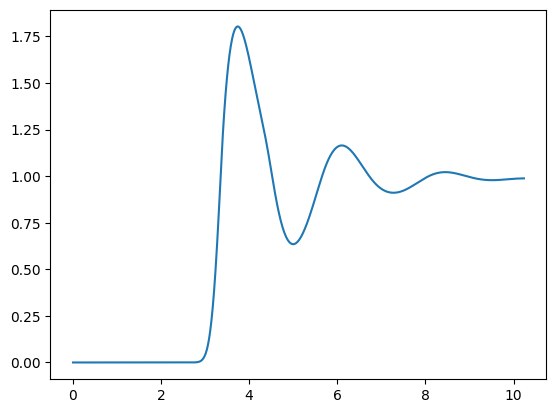

In [19]:
plt.plot(grid.rgrid, solutions.vv.correlations.gr[:, 0, 0])
plt.show()

Plot a solute-solvent RDF (Carbon-Hydrogen_water)

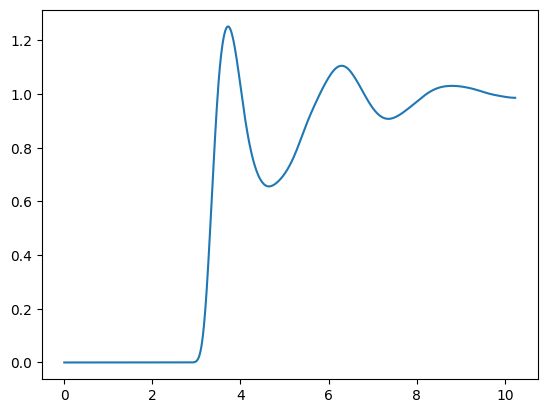

In [23]:
plt.plot(grid.rgrid, solutions.uv.correlations.gr[:, 0, 1])
plt.show()